MSE: 0.00013
R² Score: 0.50835


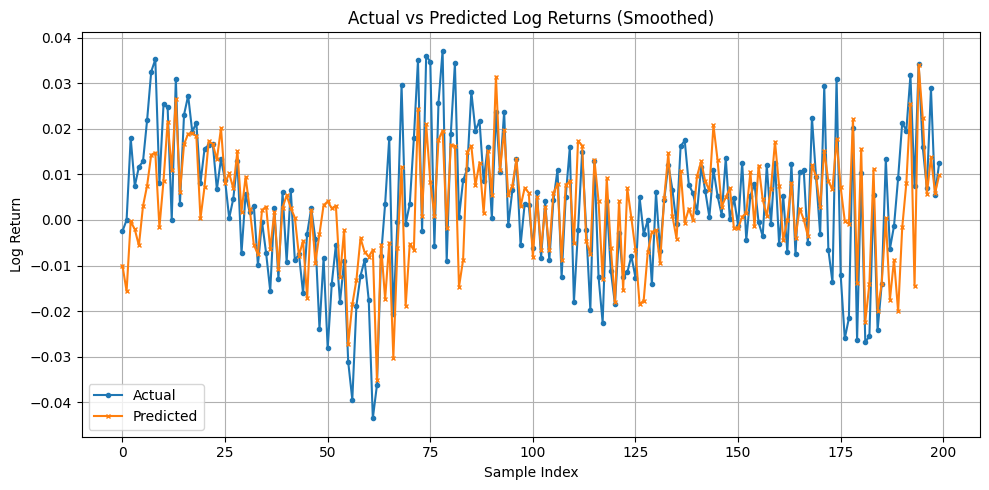

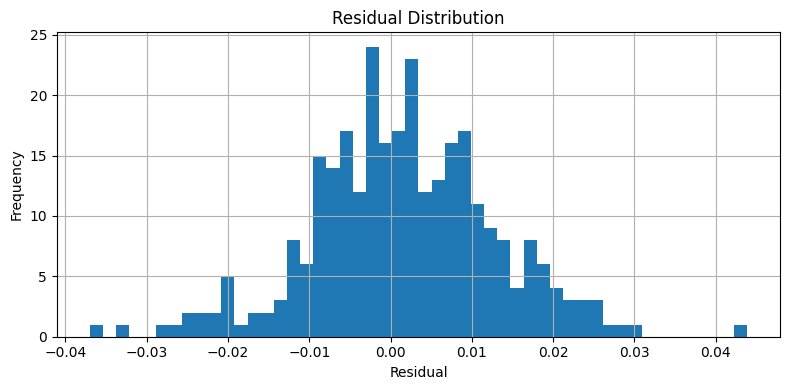

In [ ]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

client = MongoClient("mongodb://localhost:27017")  
db = client["stock_prediction_regression"]  
collection = db["merged_stock_gnews"]  

df = pd.DataFrame(list(collection.find()))
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['ticker', 'date'])

features = []

for ticker, group in df.groupby("ticker"):
    group = group.sort_values("date").copy()

    group['prev_close'] = group['close'].shift(1)
    group['return'] = group['close'].pct_change()

    group['ma_3'] = group['close'].rolling(3).mean()
    group['ma_7'] = group['close'].rolling(7).mean()

    group['diff_ma_3'] = group['close'] - group['ma_3']
    group['diff_ma_7'] = group['close'] - group['ma_7']

    group['volatility_3'] = group['return'].rolling(3).std()
    group['volatility_7'] = group['return'].rolling(7).std()

    group['future_close'] = group['close'].shift(-3)
    group['future_return'] = np.log(group['future_close'] / group['close'])

    group['future_return_smooth'] = group['future_return'].rolling(5).mean()

    group['prev_sentiment'] = group['avg_vader_score'].shift(1)
    group['prev_news_count'] = group['news_count'].shift(1)

    group['vader_roll_3'] = group['avg_vader_score'].rolling(3).mean()
    group['news_roll_3'] = group['news_count'].rolling(3).sum()

    group['sentiment_x_news'] = group['avg_vader_score'] * group['news_count']

    features.append(group)

features_df = pd.concat(features)
features_df.dropna(inplace=True)

model_df = features_df[[
    'ticker', 'date', 'close', 'avg_vader_score', 'news_count',
    'prev_sentiment', 'prev_news_count', 'vader_roll_3', 'news_roll_3',
    'sentiment_x_news', 'return', 'ma_3', 'ma_7', 'diff_ma_3', 'diff_ma_7',
    'volatility_3', 'volatility_7', 'future_return_smooth'
]]

model_df = model_df.sort_values(by="date")
split_index = int(0.8 * len(model_df))
train_df = model_df.iloc[:split_index]
test_df = model_df.iloc[split_index:]

X_train = train_df.drop(columns=['ticker', 'date', 'future_return_smooth'])
y_train = train_df['future_return_smooth']
X_test = test_df.drop(columns=['ticker', 'date', 'future_return_smooth'])
y_test = test_df['future_return_smooth']

model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.5f}")
print(f"R² Score: {r2:.5f}")


plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:200], label='Actual', marker='o', markersize=3)
plt.plot(y_pred[:200], label='Predicted', marker='x', markersize=3)
plt.title("Actual vs Predicted Log Returns (Smoothed)")
plt.xlabel("Sample Index")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=50)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
test_df = test_df.copy()
test_df['predicted_log_return'] = y_pred
test_df['actual_log_return'] = y_test.values

test_df['predicted_future_price'] = test_df['close'] * np.exp(test_df['predicted_log_return'])
test_df['actual_future_price'] = test_df['close'] * np.exp(test_df['actual_log_return'])

def generate_signal(log_return, threshold=0.01):
    if log_return > threshold:
        return "Buy"
    elif log_return < -threshold:
        return "Sell"
    else:
        return "Hold"

test_df['signal'] = test_df['predicted_log_return'].apply(generate_signal)


In [ ]:

output_collection = db["predictions_log_return"]

records_to_store = test_df[[
    'ticker', 'date', 'close',
    'predicted_log_return', 'predicted_future_price', 'signal'
]].copy()

records_to_store['date'] = records_to_store['date'].astype(str)

output_collection.insert_many(records_to_store.to_dict(orient='records'))
print(f"\nStored {len(records_to_store)} prediction records into MongoDB.")

In [ ]:
## model saving
import joblib

joblib.dump(model, "xgb_stock_model.pkl")
print("Model saved as xgb_stock_model.pkl")
